# Agent-Based Modeling

In this set of lectures, we'll study how to design agent-based models in Python. 

> An *agent-based model* (ABM) is a simulation model in which many individual entities (*agents*) interact with each other according to fixed rules. 

ABMs are often used for modeling a wide range of social and biological systems. In fact, you've already seen an example of an ABM: the SIR model of disease spred that we studied in the previous lecture is one. There, we relied on tools from NetworkX and various other familiar programming paradigms. We'll now explore the topic of agent-based modeling from a somewhat more systematic and flexible perspective. 

There exist a large number of dedicated software packages for agent-based modeling. In this course, we'll use a relatively recent package, called [Mesa](https://mesa.readthedocs.io/en/master/index.html), for agent-based modeling in Python. To install the software, run the following code in your terminal: 

```
conda activate PIC16B
conda install -c conda-forge mesa
```

# The Schelling Model of Racial Segregation

In this set of lecture notes, we will implement the Schelling model of racial residential segregation. The Schelling model is a parable of how only *mild* individual biases can lead to highly segregated outcomes. 


In the Schelling Model, individuals of two types begin arranged randomly on a grid, which is often taken to represent a city. Not all grid squares are occupied. Here's an example starting configuration

<figure class="image" style="width:50%">
  <img src="https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/_images/schelling-screencap.png" alt="">
  <figcaption><i>An example starting configuration in the Schelling model. Image credit: <a href = "https://ncase.me/polygons/"> Vi Hart and Nicky Case</a>.</i></figcaption>
</figure>

Here's how the model works: 

1. At each timestep, agents look at their surroundings. An agent is **unhappy** if fewer than 1/3 of their neighbors have the same type, and is **happy** otherwise. 
2. All **unhappy** agents pick a random empty spot and move there. All **happy** agents stay where they are. 

We run the model until all agents are happy. The fundamental result of the model is that, even though agents have only mild biases -- they simply prefer not to be outnumbered --  acting on their preferences can still lead to highly segregated outcomes, like this: 

<figure class="image" style="width:50%">
  <img src="https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/_images/schelling-final.png" alt="">
  <figcaption><i>An example final configuration in the Schelling model. Image credit: <a href = "https://ncase.me/polygons/"> Vi Hart and Nicky Case</a>.</i></figcaption>
</figure>

For an excellent interactive demonstration of the Schelling Model, check out [this blog post](https://ncase.me/polygons/) by Vi Hart and Nicky Case.  

### A Note on History

The Schelling model does not include any concepts of historical oppression, wealth, or power, all of which contribute to racial segregation. The message of the Schelling model is that these factors are not **needed** for segregation -- mildly racist individual preferences would be enough. It is important, however, not to confuse this mathematical parable with the actual historical circumstances of racial segregation in the US or elsewhere. In most societies, including the US, racial segregation arises because of systematic oppression enforced by policy, violence, and erasure. 

### Sources

These lecture notes are closely based on the [Schelling model example](https://github.com/projectmesa/mesa/tree/main/examples/schelling) in the [official Mesa repository](https://github.com/projectmesa/mesa). They also draw on the [Introductory Tutorial](https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html) from the official Mesa documentation.  

# Implementing the Schelling Model

Let's start by implementing a bare-bones model. While there is some flexibility in how one does this, there are a few common features of most Mesa models: 

1. There must be an *agent* class, which should inherit from `mesa.Agent`. This class specifies the properties and behaviors of an individual agent in the simulation. 
    - This class must call  `mesa.Agent.__init__()` as part of its `__init__()` method. 
    - This class must have a `step()` method which describes the primary individual behavior. 
2. There must be a *model* class, which should inherit from `mesa.Model`. 
    - The `__init__()` method of this class is responsible for creating agents with their properties, as well as the space (often a grid) on which the simulation unfolds. 
    - This class must also have a `step()` method which provides a complete description of what happens in a single model time step. Often, this involves using a `Schedule` to call the `step()` method of each of the agents in some specified sequence. 
    
Let's write a very simple model that demonstrates some of these requirements. Our model won't really do very much yet, but it will demonstrate the key techniques of defining the agent and model, adding agents to the model, and calling the `step()` methods. 

In [1]:
from mesa import Model, Agent
from mesa.time import RandomActivation

class ToyAgent(Agent):
    
    def __init__(self, name, model):
        super().__init__(name, model)
        self.name = name
    
    def step(self):
        print(f"Hi, I'm Agent 00{self.name}!")

class ToyModel(Model):
    
    def __init__(self, n_agents):
        
        self.schedule = RandomActivation(self)
        
        for i in range(n_agents):
            agent = ToyAgent(i, self)
            
            # important and easy to forget! 
            # this line "registers" the agent
            # with the scheduler so that the 
            # agent's step() method will be
            # called when the scheduler's 
            # is. 
            self.schedule.add(agent)
                
    def step(self):
        self.schedule.step()

Let's demonstrate the behavior of our toy model: 

In [2]:
TM = ToyModel(10)

In [3]:
TM.step()

Hi, I'm Agent 007!
Hi, I'm Agent 006!
Hi, I'm Agent 003!
Hi, I'm Agent 008!
Hi, I'm Agent 004!
Hi, I'm Agent 005!
Hi, I'm Agent 002!
Hi, I'm Agent 009!
Hi, I'm Agent 001!
Hi, I'm Agent 000!


Observe that, each time we call `TM.step()`, the model sweeps through the various agents and calls their individual `step()` methods. This is because we created a `RandomActivation` schedule, and added each of the agents to this schedule.

With our architecture in place, our next step is learn how to implement more interesting behaviors. 

## Spatial Grids

The Schelling model usually evolves on a grid. At the moment, we don't have a grid incorporated. Fortunately, this is easy to bring in. We simply need to add a `SingleGrid` object with specified width and height. The `torus` argument of the grid determines whether the edges "wrap around." If it is selected, then walking off the left side of the grid will put you back on the right side. This is often visualized as allowing the grid to lie on the surface of a torus, or donut: 

<figure class="image" style="width:30%">
  <img src="https://i.stack.imgur.com/ZZrv4.png" alt="">
  <figcaption><i>A toroidal grid.</i></figcaption>
</figure>

The modifications we need to make to our previous code are relatively simple: 

1. We need to give each `ToyAgent` a `pos`ition. 
2. We need to give the model a `grid` instance variable. 
3. We need to modify our initialization of agents so that we call `self.grid.position_agent(agent, pos)` in order to place each agent on the grid. 

In [4]:
from mesa.space import SingleGrid

class ToyAgent(Agent):
    
    # adding a pos instance variable so that each agent can remember
    # where they are. Note that the pos can take the place of the name. 
    def __init__(self, pos, model):
        super().__init__(pos, model)
        self.pos = pos
    
    def step(self):
        print(f"Hi, I'm an agent at {self.pos}!")

class ToyModel(Model):
    
    # need to specify width, height, and density of agents
    # in the grid. 
    def __init__(self, width, height, density):
        
        self.schedule = RandomActivation(self)
        
        # create the grid
        self.grid = SingleGrid(width, height, torus=True)
        
        # loop through the grid, and add agents so that the 
        # overall density is roughly equal to the passed 
        # density
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if self.random.random() < density:
                
                agent = ToyAgent(pos = (x, y), model = self)
                self.schedule.add(agent)    
                self.grid.position_agent(agent, (x, y))
            
    # this doesn't change. 
    def step(self):
        self.schedule.step()

Now we can again instantiate our model. This time, we need to pass `width`, `height`, and `density`. Here, we're creating a 10x10 grid in which roughly 10% of cells have agents in them. 

In [5]:
TM = ToyModel(10, 10, 0.1)
TM.step()

Hi, I'm an agent at (5, 0)!
Hi, I'm an agent at (1, 3)!
Hi, I'm an agent at (8, 5)!
Hi, I'm an agent at (9, 4)!
Hi, I'm an agent at (1, 4)!
Hi, I'm an agent at (4, 5)!
Hi, I'm an agent at (9, 1)!


It's also possible to directly extract the grid and visualize it using familiar tools. In a later lecture, however, we'll see some much better ways to visualize the grid. 

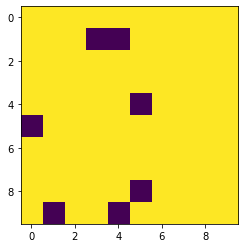

In [6]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(np.array(TM.grid.grid) == None)

# A Basic Schelling Model

We're now ready to construct a simple version of the Schelling model. Here are the remaining ingredients we need to bring in: 

1. Agents need to have *types* associated with them. 
2. The agents `step()` method should check whether the agent is "happy" (i.e. not surrounded by too many neighbors of different `type`, and move them to an empty grid cell if not. The `SingleGrid` class we've used to create the grid provides several useful methods for handling this logic.  

In [7]:
class SchellingAgent(Agent):
    
    # adding a pos instance variable so that each agent can remember
    # where they are. Note that the pos can take the place of the name. 
    def __init__(self, pos, agent_type, homophily, model):
        super().__init__(pos, model)
        self.pos = pos
        self.type = agent_type
        self.homophily = homophily
    
    def step(self):
        
        pct_similar_neighbors = np.mean([
            self.type == other.type for other in self.model.grid.neighbor_iter(self.pos)
        ])
        
        if pct_similar_neighbors < self.homophily:
            self.model.grid.move_to_empty(self)
            self.model.moved += 1   
        
class SchellingModel(Model):
    
    # need to specify width, height, and density of agents
    # in the grid. 
    def __init__(self, width, height, density, homophily):
        
        self.schedule = RandomActivation(self)
        
        # create the grid
        self.grid = SingleGrid(width, height, torus=True)
        
        # loop through the grid, and add agents so that the 
        # overall density is roughly equal to the passed 
        # density
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if self.random.random() < density:
                
                agent_type = np.random.choice(["triangle", "square"])
                
                agent = SchellingAgent(pos = (x, y), 
                                 agent_type = agent_type, 
                                 homophily = homophily, 
                                 model = self)
                
                self.schedule.add(agent)    
                self.grid.position_agent(agent, (x, y))
            
    # this doesn't change, except that we will add a counter for the number of happy agents
    # who don't move in this timestep
    def step(self):
        self.moved = 0
        self.schedule.step()
        print(f"{self.moved} agents moved in this timestep")

In [8]:
SM = SchellingModel(20, 20, 0.9, 0.5)
SM.step()

135 agents moved in this timestep


Here's a function to plot the model state. Dark purple squares are empty; green squares are agents of type `triangle`, and yellow squares are agents of type `square`. 

In [9]:
def viz_state(SM, ax):
    G = np.array(SM.grid.grid)
    to_viz = np.zeros(G.shape)
    
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
            if G[i,j] is not None:
                if G[i,j].type == "triangle":
                    to_viz[i,j] = 1.0
                elif G[i,j].type == "square":
                    to_viz[i,j] = -1.0
    ax.imshow(to_viz, cmap = "Spectral", vmin = -1.5, vmax = 1.5)

Now we're ready to visualize the evolution of our model. 

246 agents moved in this timestep
193 agents moved in this timestep
150 agents moved in this timestep
119 agents moved in this timestep
89 agents moved in this timestep
78 agents moved in this timestep
68 agents moved in this timestep
68 agents moved in this timestep
67 agents moved in this timestep
51 agents moved in this timestep


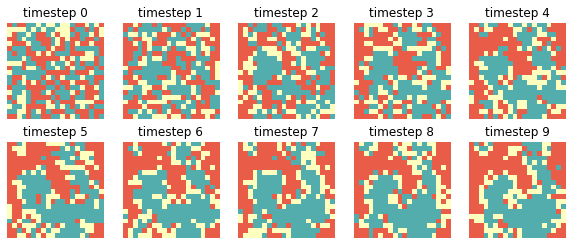

In [10]:
fig, axarr = plt.subplots(2, 5, figsize = (10, 4))
SM = SchellingModel(20, 20, 0.8, 0.7)

t = 0
for ax in axarr.flatten():
    ax.axis("off")
    ax.set(title = f"timestep {t}")
    viz_state(SM, ax)
    t += 1
    SM.step()

We observe the characteristic separation of an initially spatially mixed population into large regions of homogeneous types. 

In coming lectures, we'll learn how to visualize these processes more gracefully; how to collect data from simulations; and how to implement more complex models. 